In [2]:
import multiprocessing

import matplotlib.pyplot as plt
import numpy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torchvision import transforms

import utils.dlc_practical_prologue as prologue

%load_ext autoreload
%autoreload 2

### Examine data format and normalize

In [3]:
def load_data(batch_size=20):
    transform = transforms.Compose(
    [
        # transforms.ToTensor(),
        transforms.Lambda(lambda x: x.div(255))]
    )

    train_input, train_target, train_classes,\
        test_input, test_target, test_classes = prologue.generate_pair_sets(
            1000, transform=transform)

    trainset = TensorDataset(train_input, train_target)
    testset = TensorDataset(test_input, test_target)

    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers= 1)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=True, num_workers= 1)
    
    return trainloader, testloader

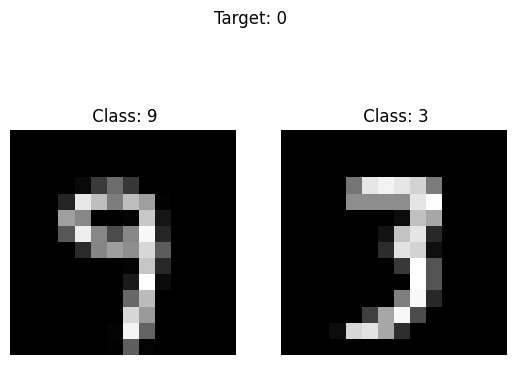

Train input shapetorch.Size([1000, 2, 14, 14])
Train target shapetorch.Size([1000])
Train classes shapetorch.Size([1000, 2])
---
Test input shape torch.Size([1000, 2, 14, 14])
Test target shape torch.Size([1000])
Test classes shape torch.Size([1000, 2])


In [4]:

BATCH_SIZE = 50
transform = transforms.Compose(
    [
        # transforms.ToTensor(),
        transforms.Lambda(lambda x: x.div(255))]
)

train_input, train_target, train_classes,\
    test_input, test_target, test_classes = prologue.generate_pair_sets(
        1000, transform=transform)

trainset = TensorDataset(train_input, train_target)
testset = TensorDataset(test_input, test_target)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers= 1)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers= 1)

# target: 1 if digit 1 <= digit 2, 
#         0 otherwise

# Plotting the first 5 pairs of images
for i in range(1):
    for j in range(2):
        plt.subplot(1, 2, j+1)
        plt.imshow(train_input[i, j].view(14, 14), cmap='gray')
        # plot the target and its class in the title
        plt.suptitle(f"Target: {train_target[i]}")
        plt.title(f' Class: {train_classes[i, j]}')
        plt.axis('off')
    plt.show()

# print the shapes of the tensors
print(f"Train input shape{train_input.shape}")
print(f"Train target shape{train_target.shape}")
print(f"Train classes shape{train_classes.shape}")
print('---')
print(f"Test input shape {test_input.shape}")
print(f"Test target shape {test_target.shape}")
print(f"Test classes shape {test_classes.shape}")


In [5]:
print(train_input[0,1].shape)
print(train_input[0,1].dtype)
print(train_input[0,1].max())
print(train_input[0,1].min())

torch.Size([14, 14])
torch.float32
tensor(0.9931)
tensor(0.)


### Baseline

In [6]:
print(torch.mean(train_target.float()))
print(torch.mean(test_target.float()))

tensor(0.5510)
tensor(0.5260)


In [7]:
baseline_target_pred = torch.ones_like(train_target)

# compute accuracy of the baseline and the test target
acc = 100 * (baseline_target_pred == test_target).sum().item() / test_target.shape[0]
print(f"Baseline accuracy: {acc:.2f}%")

Baseline accuracy: 52.60%


### Convnet without Weight Sharing

In [8]:
torch.cuda.is_available()

False

In [9]:
# # 68%

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(2, 16, (3, 3))
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(16, 32, (3,3))
#         self.fc1 = nn.Linear(32*5*5, 200)
#         self.fc2 = nn.Linear(200, 1)
#         # self.fc3 = nn.Linear(32, 10)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         #print(x.shape)
#         #x = self.pool(x)
#         x = F.relu(self.conv2(x))
#         #print(x.shape)
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)   # flatten features
#         #print(x.shape) 2x800

#         x = self.fc1(x)
#         x = self.fc2(x)
#         x = F.softmax(x, dim=0) # return a probability
#         # x = self.fc3(x)
#         return x

# net = Net()

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1_1 = nn.Conv2d(1, 16, (3, 3))
        self.conv1_2 = nn.Conv2d(16, 32, (3,3))
        self.conv2_1 = nn.Conv2d(1, 16, (3, 3))
        self.conv2_2 = nn.Conv2d(16, 32, (3,3))
        self.max_pool = nn.MaxPool2d(kernel_size=(2,2),stride=2)
        self.fc1 = nn.Linear(32*5*5*2, 40)
        self.fc2 = nn.Linear(40, 20)
        self.fc3 = nn.Linear(20, 1)
        # self.fc4 = nn.Linear(32,1)

    def forward(self, input):
        img1 = torch.narrow(input,dim=1,start=0,length=1)
        img2 = torch.narrow(input,dim=1,start=1,length=1)
        x = self.conv1_1(img1)
        x = F.relu(x)
        x = self.conv1_2(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = x.view(x.size(0), -1)
        
        y = self.conv2_1(img2)
        y = F.relu(y)
        y = self.conv2_2(y)
        y = F.relu(y)
        y = self.max_pool(y)
        y = y.view(y.size(0), -1)

        z = torch.cat((x,y), 1)
        z = self.fc1(z)
        z = F.relu(z)
        z = self.fc2(z)
        z = F.relu(z)
        z = self.fc3(z)
        # z = F.relu(z)
        # z = self.fc4(z)
        z = torch.sigmoid(z)
        return z


In [23]:
tb = SummaryWriter('./runs/no_weight_sharing/graph/')
model_view = Net()
trainloader, testloader = load_data()
images, labels = next(iter(trainloader))
# grid = torchvision.utils.make_grid(images)
# tb.add_image("images", grid)
tb.add_graph(model_view, images)
tb.close()

In [24]:
def test_accuracy(net, testloader):

    acc = 0
    for i, data in enumerate(testloader, 0):
        
        inputs, labels = data

        # Concatenate both images side-by-side
        # left, right = inputs[:, 0], inputs[:, 1]
        # inputs = torch.cat((left, right), 2)
        # inputs = torch.unsqueeze(inputs, 1)
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        inputs, labels = inputs.to(device), labels.to(device)
    
        outputs = net(inputs)
        equality = (labels.reshape(-1, 1) == outputs.round().to(torch.int))
        acc += equality.to(torch.float).mean()

    return acc.item() / (i+1)

In [25]:
def train_model(model, trainloader, testloader, num_epochs=25, tb_dir=None ):
    
    criterion = nn.BCELoss()
    # optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.5)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # print(device)

    model.to(device)
    
    # add summary writer in separate folder with differnet name
    tb = SummaryWriter(tb_dir)
    
    for epoch in range(num_epochs):  

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()   # zero the gradient buffers
            outputs = model(inputs)
            
            loss = criterion(outputs, labels.reshape(-1, 1).type_as(outputs))
            loss.backward()
        
            optimizer.step()


            # print statistics
            running_loss += loss.item()
            if i % 10 == 0:    # print every 2000 mini-batches
                print('[%d/ %d, %5d] loss: %.3f' % 
                    (epoch + 1,num_epochs, i + 1, running_loss / (1000/trainloader.batch_size)), end='\r')
                running_loss = 0.0
        
        
        train_acc = test_accuracy(model, trainloader)
        test_acc = test_accuracy(model, testloader)
        
        tb.add_scalar("Loss", loss, epoch)
        tb.add_scalars("Accuracy", {"train": train_acc, "test": test_acc}, epoch)

        
    tb.close()

### Performance Evaluation

In [26]:
# test model 10 times and save accuracies for mean and std
accuracies = []
ROUNDS = 10
for i in range(ROUNDS):
    trainloader, testloader = load_data(batch_size=20)
    net = Net()
    train_model(net, trainloader,testloader, num_epochs=25, tb_dir=f'./runs/no_weight_sharing/round_{i}/')
    acc = test_accuracy(net, testloader)
    accuracies.append(acc*100)
    print(f'Accuracies: [{", ".join([f"{acc:.3f}" for acc in accuracies])}]', end='\r')


Mean accuracy of the network on the 1000 test images:     82.9 % (+/- 1.4 %)


Text(0.5, 1.0, 'Accuracy of the network on the test images')

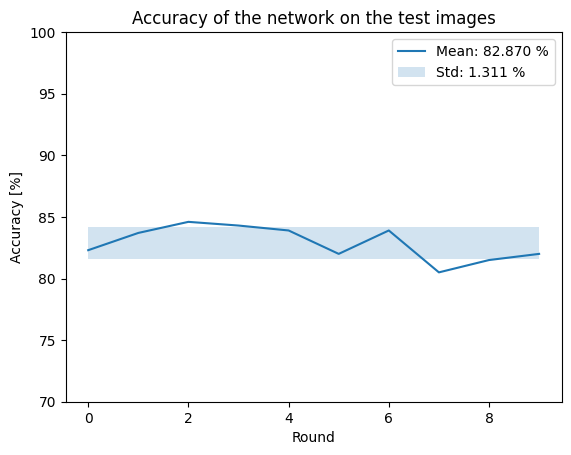

In [35]:
print(f'Mean accuracy of the network on the {len(testloader.dataset)} test images: \
    {torch.mean(torch.tensor(accuracies)):.1f} % (+/- {torch.std(torch.tensor(accuracies)):.1f} %)')

mean = np.mean(accuracies)
std = np.std(accuracies)
# plot accuracies and fill_between std
plt.figure()
plt.plot(accuracies)
plt.fill_between(range(len(accuracies)), mean-std, mean+std, alpha=0.2)
plt.legend([f'Mean: {mean:.3f} %', f'Std: {std:.3f} %'])
plt.xlabel('Round')
plt.ylabel('Accuracy [%]')
plt.ylim((70, 100))

plt.title('Accuracy of the network on the test images')

In [28]:
model_view = Net()
summary(model_view,(2,14,14))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 12, 12]          160
├─Conv2d: 1-2                            [-1, 32, 10, 10]          4,640
├─MaxPool2d: 1-3                         [-1, 32, 5, 5]            --
├─Conv2d: 1-4                            [-1, 16, 12, 12]          160
├─Conv2d: 1-5                            [-1, 32, 10, 10]          4,640
├─MaxPool2d: 1-6                         [-1, 32, 5, 5]            --
├─Linear: 1-7                            [-1, 32]                  51,232
├─Linear: 1-8                            [-1, 64]                  2,112
├─Linear: 1-9                            [-1, 128]                 8,320
├─Linear: 1-10                           [-1, 1]                   129
Total params: 71,393
Trainable params: 71,393
Non-trainable params: 0
Total mult-adds (M): 1.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.27
Estimated Total Size (MB): 

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 12, 12]          160
├─Conv2d: 1-2                            [-1, 32, 10, 10]          4,640
├─MaxPool2d: 1-3                         [-1, 32, 5, 5]            --
├─Conv2d: 1-4                            [-1, 16, 12, 12]          160
├─Conv2d: 1-5                            [-1, 32, 10, 10]          4,640
├─MaxPool2d: 1-6                         [-1, 32, 5, 5]            --
├─Linear: 1-7                            [-1, 32]                  51,232
├─Linear: 1-8                            [-1, 64]                  2,112
├─Linear: 1-9                            [-1, 128]                 8,320
├─Linear: 1-10                           [-1, 1]                   129
Total params: 71,393
Trainable params: 71,393
Non-trainable params: 0
Total mult-adds (M): 1.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.27
Estimated Total Size (MB): 

### model saving

In [29]:
# save model parameters
torch.save(net.state_dict(), './Models/cnn_no_weight_sharing.pt')

In [30]:
# load model parameters
model1 = Net()
model1.load_state_dict(torch.load('./Models/cnn_no_weight_sharing.pt'))
model1.eval()

Net(
  (conv1_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv1_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=1, bias=True)
)

In [31]:
pytorch_total_params = sum(p.numel() for p in model1.parameters())
pytorch_total_params

71393